In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/billboards-signs-and-branding/billboards-signs-and-branding.2022-08-07T102240Z/IMAGE_LICENSE.txt
/kaggle/input/billboards-signs-and-branding/billboards-signs-and-branding.2022-08-07T102240Z/ATTRIBUTION.txt
/kaggle/input/billboards-signs-and-branding/billboards-signs-and-branding.2022-08-07T102240Z/ANNOTATION_LICENSE.txt
/kaggle/input/billboards-signs-and-branding/billboards-signs-and-branding.2022-08-07T102240Z/annotations/BulkyWildIndochinahogdeer.csv
/kaggle/input/billboards-signs-and-branding/billboards-signs-and-branding.2022-08-07T102240Z/annotations/AntiquewhitePinkAfricanhornbill.csv
/kaggle/input/billboards-signs-and-branding/billboards-signs-and-branding.2022-08-07T102240Z/annotations/LikelyGaseousJunco.csv
/kaggle/input/billboards-signs-and-branding/billboards-signs-and-branding.2022-08-07T102240Z/annotations/TealEagerAzurewingedmagpie.csv
/kaggle/input/billboards-signs-and-branding/billboards-signs-and-branding.2022-08-07T102240Z/annotations/YellowBabyishRainbo

In [1]:
# os.listdir('/kaggle/input/billboards-signs-and-branding/billboards-signs-and-branding.2022-08-07T102240Z/annotations/')
import math, os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import *
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
FileList = []
base_path = '/kaggle/input/billboards-signs-and-branding/billboards-signs-and-branding.2022-08-07T102240Z/annotations/'
for file in os.listdir('/kaggle/input/billboards-signs-and-branding/billboards-signs-and-branding.2022-08-07T102240Z/annotations/'):
    df = pd.read_csv(base_path + file)
    FileList.append(df)

In [3]:
dfMerge = pd.concat(FileList)
dfMerge

,x1,y1,x2,y2,label
0,0.168249,0.425154,0.267916,0.568296,billboard
1,0.318605,0.524632,0.361889,0.555387,signage
2,0.000000,0.537489,0.017173,0.564436,signage
3,0.039875,0.447050,0.088325,0.466983,signage
4,0.552029,0.514344,0.574703,0.546902,signage
...,...,...,...,...,...
3,0.000000,0.189581,0.039179,0.215524,signage
4,0.483662,0.194337,0.617987,0.211632,signage
5,0.769676,0.146930,0.918090,0.173866,signage
6,0.792440,0.247165,0.819052,0.257889,signage


In [4]:
dfMerge.label.unique()

array(['billboard', 'signage', 'branding'], dtype=object)

In [5]:
Target = {k: v for k, v in zip(['billboard', 'signage', 'branding'], list(range(3)))}
Target

{'billboard': 0, 'signage': 1, 'branding': 2}

In [6]:
for i in range(dfMerge.shape[0]):
    dfMerge.iloc[i, -1] = Target[dfMerge.iloc[i, -1]]

In [7]:
X = np.array(dfMerge.iloc[:, 0:-1])
y = np.asarray(dfMerge.iloc[:, -1]).astype('int64')

In [8]:
def create_dataset(X_data, y_data):
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    X_train = tf.cast(X_train, tf.float32)
    X_test = tf.cast(X_test, tf.float32)
    y_train = tf.cast(y_train, tf.int64)
    y_test = tf.cast(y_test, tf.int64)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_dataset(X, y)

2022-08-15 01:55:50.134770: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
X_train[0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-1.8179522 , -0.05690309, -1.8300292 ,  0.10933255], dtype=float32)>

In [11]:
def GELU(x):
    res = 0.5 * x * (1 + tf.nn.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * (x ** 3))))
    return res


class ResMLPBlock(tf.keras.layers.Layer):
    def __init__(self, units, residual_path):
        super(ResMLPBlock, self).__init__()
        self.residual_path = residual_path
        self.D1 = Dense(units, activation='relu')
        self.D2 = Dense(units, activation='relu')

        if self.residual_path:
            self.D3 = Dense(units)
            self.D4 = Dense(units)

    def call(self, inputs):
        residual = inputs

        x = self.D1(inputs)
        y = self.D2(x)

        if self.residual_path:
            residual = self.D3(inputs)
            residual = GELU(residual)
            residual = self.D4(residual)
            residual = GELU(residual)

        output = y + residual
        return output

In [12]:
class ResMLP(tf.keras.Model):
    def __init__(self, initial_filters, block_list, num_classes):
        super(ResMLP, self).__init__()
        self.initial_filters = initial_filters
        self.block_list = block_list

        self.D1 = Dense(self.initial_filters, activation='relu')
        self.B1 = BatchNormalization()

        self.blocks = tf.keras.models.Sequential()
        for block_id in range(len(block_list)):
            for layer_id in range(block_list[block_id]):
                if block_id != 0 and layer_id == 0:
                    block = ResMLPBlock(units=self.initial_filters, residual_path=True)
                else:
                    block = ResMLPBlock(units=self.initial_filters, residual_path=False)
                self.blocks.add(block)
            self.initial_filters *= 2

        self.D2 = Dense(num_classes, activation='softmax')


    def call(self, inputs):
        x = self.D1(inputs)
        x = self.B1(x)
        x = self.blocks(x)
        y = self.D2(x)
        return y

In [13]:
net = ResMLP(initial_filters=32, block_list=[2, 2, 2], num_classes=3)

net.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['sparse_categorical_accuracy'])

# checkpoint_save_path = './checkpoint/ResMLP.ckpt'
# if os.path.exists(checkpoint_save_path + '.index'):
#     print('-------------------------------------Loading-------------------------------------')
#     net.load_weights(checkpoint_save_path)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
#                                                  save_weights_only=True,
#                                                  save_best_only=True)

history = net.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

net.summary()

2022-08-15 01:59:09.076365: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
17/17 [==============================] - 3s 38ms/step - loss: 0.9279 - sparse_categorical_accuracy: 0.6602 - val_loss: 0.9046 - val_sparse_categorical_accuracy: 0.6395
Epoch 2/50
17/17 [==============================] - 0s 10ms/step - loss: 0.8168 - sparse_categorical_accuracy: 0.6951 - val_loss: 0.9823 - val_sparse_categorical_accuracy: 0.6279
Epoch 3/50
17/17 [==============================] - 0s 10ms/step - loss: 0.7631 - sparse_categorical_accuracy: 0.6990 - val_loss: 0.9042 - val_sparse_categorical_accuracy: 0.6570
Epoch 4/50
17/17 [==============================] - 0s 10ms/step - loss: 0.7422 - sparse_categorical_accuracy: 0.7126 - val_loss: 0.9179 - val_sparse_categorical_accuracy: 0.6802
Epoch 5/50
17/17 [==============================] - 0s 10ms/step - loss: 0.6991 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.9132 - val_sparse_categorical_accuracy: 0.6395
Epoch 6/50
17/17 [==============================] - 0s 10ms/step - loss: 0.7160 - sparse_categorical_accu

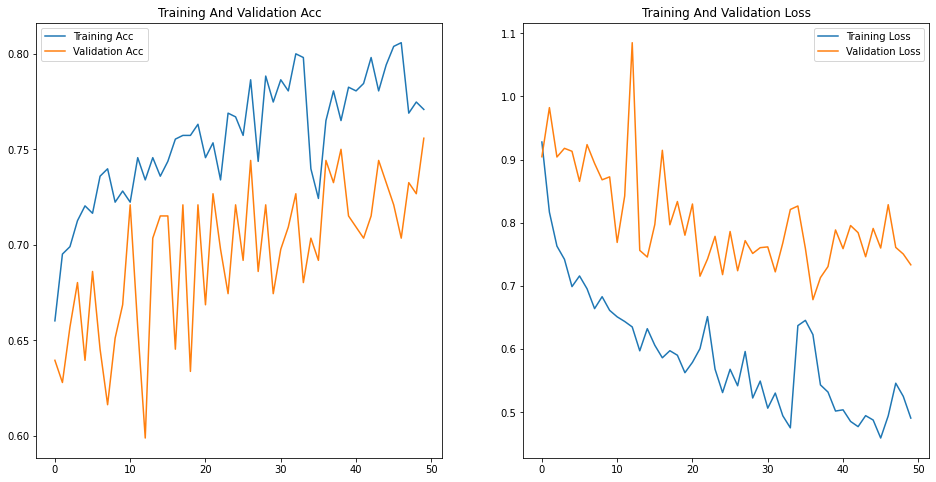

In [14]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.title('Training And Validation Acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training And Validation Loss')

plt.legend()
plt.show()